<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [3]:
#!pip install scikit-learn==1.0.2
#!pip install catboost

In [4]:
import pandas as pd
import numpy as np
import numpy.matlib
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

## Подготовка

In [5]:
pth1 = r'C:\Users\dinos\Downloads\taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1,  index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2,  index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [5]:
def info(df):
    display(df.head(5))
    display(df.info()) 
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print(f'Количество пропусков: {df.isna().sum()}')

In [6]:
info(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Количество дубликатов: 26415
Количество пропусков: num_orders    0
dtype: int64


In [7]:
data['num_orders'].sort_values()

datetime
2018-04-29 06:30:00      0
2018-05-31 07:00:00      0
2018-04-25 06:40:00      0
2018-04-13 07:10:00      0
2018-04-01 06:20:00      0
                      ... 
2018-08-30 17:50:00     95
2018-08-27 02:00:00     98
2018-08-13 02:30:00     99
2018-08-13 02:20:00    119
2018-08-27 02:10:00    119
Name: num_orders, Length: 26496, dtype: int64

In [8]:
data.sort_index(inplace=True)

In [9]:
data = data.resample('1H').sum()

## Анализ

In [10]:
decomposed = seasonal_decompose(data)

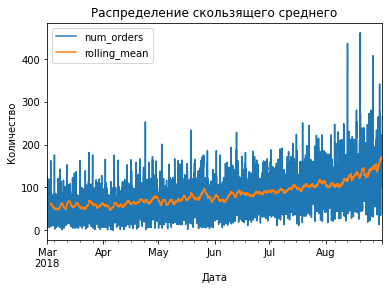

In [13]:
data['rolling_mean'] = data.rolling(50).mean() 
data.plot()
plt.title(f"Распределение скользящего среднего")
plt.ylabel("Количество")
plt.xlabel('Дата')
plt.show()

Text(0.5, 0, 'Дата')

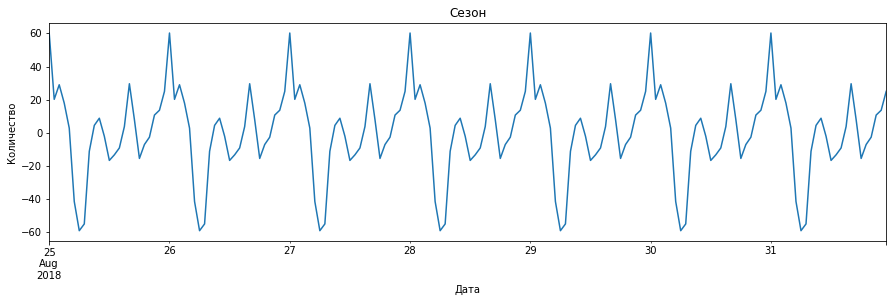

In [14]:
plt.figure(figsize=(15,4))
decomposed.seasonal.tail(24*7).plot(ax=plt.gca())
plt.title('Сезон')
plt.ylabel("Количество")
plt.xlabel('Дата')

Text(0.5, 0, 'Дата')

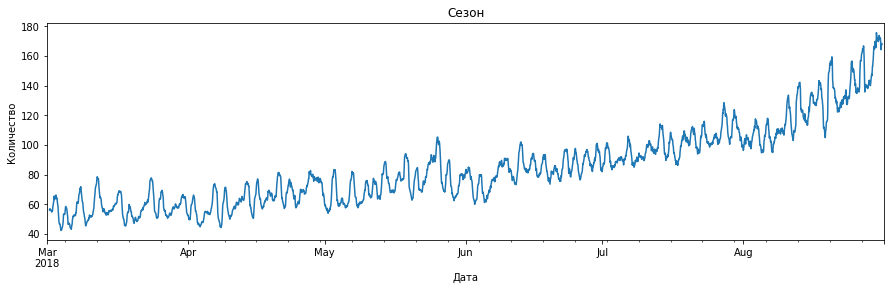

In [15]:
plt.figure(figsize=(15, 4))
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel("Количество")
plt.xlabel('Дата')

Text(0.5, 0, 'Дата')

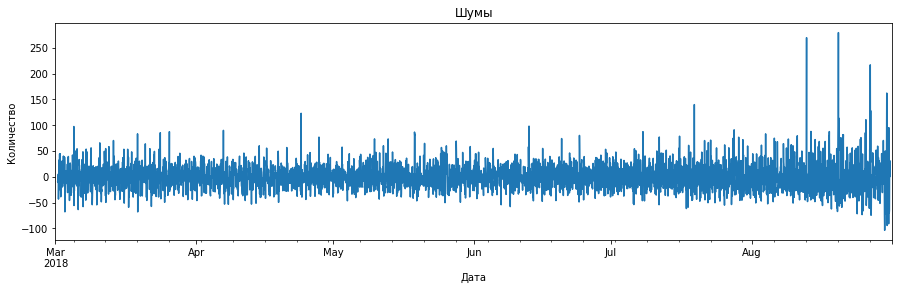

In [16]:
plt.figure(figsize=(15, 4))
decomposed.resid.plot(ax=plt.gca())
plt.title('Шумы')
plt.ylabel("Количество")
plt.xlabel('Дата')

Выводы:

* Отмечается устойчивая тенденция равномерного увеличения количества заказов с редкими незначительными снижениями. 
* Наблюдается суточная сезонность: спад в ночное время, увеличение утром и днем, с пиковыми значениями к вечеру.

## Обучение

In [14]:
# Создадим функцию, которая добавляет признаки для обучения модели 
def make_features(df, max_lag, rolling_mean_size):
    """
    Функция получает на вход оригинальный датафрейм и возвращает датафрейм с новыми признаками
    
    :param data (pd.DataFrame): Оригинальный датафрейм 
    :param max_lag(int): Максимальное предыдущее значение временного ряда
    :param rolling_mean_size(int): Значение ширины скользящего окна
    :return(pd.DataFrame): Датафрейм с новыми признаками 
    """
    data_copy = df.copy(deep=True)
    data_copy['month'] = data_copy.index.month
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour

    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_copy.dropna(inplace=True)

    return data_copy

In [15]:
# Создадим датасет для обучения моделей
data_ml = make_features(data, 180, 180)
print(f'Размер оригинального датасета: {data.shape}')
print(f'Размер обновленного датасета: {data_ml.shape}')

Размер оригинального датасета: (4416, 2)
Размер обновленного датасета: (4236, 186)


In [16]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

# Разбиваем фичи и таргет
X = data_ml.drop('num_orders', axis=1)
y = data_ml['num_orders']

# Разбиваем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [17]:
# Настройка пайплайна для моделей
lin_reg_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('regressor', LinearRegression())
])

rf_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('regressor', RandomForestRegressor(random_state=RANDOM_STATE))
])

catboost_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))
])

In [18]:
# Кросс-валидация с TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)

# Список моделей для обучения
models_pipes = [lin_reg_pipe, rf_pipe, catboost_pipe]
model_names = ['LinearRegression', 'RandomForest', 'CatBoost']

# Список для результатов
models = []

In [19]:
for model, name in zip(models_pipes, model_names):
    scores = cross_val_score(
        model, 
        X_train, 
        y_train, 
        cv=cv, 
        n_jobs=-1, 
        scoring='neg_root_mean_squared_error'
    )
    rmse_cv = (-1) * (sum(scores) / len(scores))
    print(f'RMSE {name} на кросс-валидации: {rmse_cv}')
    
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    print(f'RMSE {name} на тренировочной выборке: {rmse_train}')
    print('---')
    
    models.append([model, rmse_cv, rmse_train])

RMSE LinearRegression на кросс-валидации: 22.830278734417416
RMSE LinearRegression на тренировочной выборке: 20.325982019769143
---
RMSE RandomForest на кросс-валидации: 23.032472178617905
RMSE RandomForest на тренировочной выборке: 8.073464833491785
---
RMSE CatBoost на кросс-валидации: 22.82939052677035
RMSE CatBoost на тренировочной выборке: 8.624900193963626
---


In [20]:
# Сортировка по лучшему RMSE
models_analysis = pd.DataFrame(models, columns=['model', 'RMSE_cv', 'RMSE_train'])
models_analysis.sort_values('RMSE_cv', inplace=True)

## Тестирование

In [21]:
# Лучшая модель на тестовой выборке
best_model_info = models_analysis.iloc[0]
best_model = best_model_info['model']

# Предсказания на тестовой выборке
y_pred = best_model.predict(X_test)

# Вычисляем RMSE на тестовой выборке
best_rmse = mean_squared_error(y_test, y_pred, squared=False)

# Выводим информацию о лучшей модели, её параметры и RMSE
print(f'Лучшая модель: {type(best_model.named_steps["regressor"]).__name__}')
print(f'Параметры модели: {best_model.named_steps["regressor"].get_params()}')
print(f'RMSE лучшей модели на тестовой выборке: {best_rmse}')

Лучшая модель: CatBoostRegressor
Параметры модели: {'loss_function': 'RMSE', 'verbose': False, 'random_state': 42}
RMSE лучшей модели на тестовой выборке: 36.80958977673447


In [22]:
def display_result(target, pred, rmse):
    """
    Функция отображает график реальных значений и предсказаний модели.
    
    :param target: Реальные значения
    :param pred: Предсказанные значения
    :param rmse: Значение метрики RMSE
    :return: График
    """
    result = target.to_frame().reset_index()
    result['prediction'] = pd.Series(pred)
    result.set_index('datetime', inplace=True)
    
    plt.figure(figsize=(12, 6))
    plt.plot(result.index, result['num_orders'], label='Actual')
    plt.plot(result.index, result['prediction'], label='Prediction', linestyle='--')
    plt.title(f'Actual vs Predicted (RMSE={rmse:.2f})')
    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.legend()
    plt.grid(True)
    plt.show()

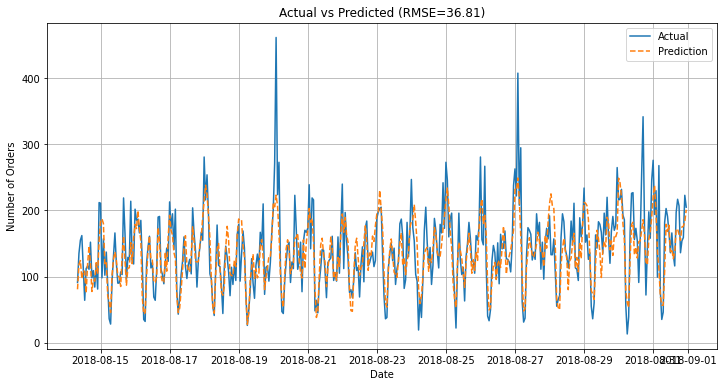

In [23]:
display_result(y_test, y_pred, best_rmse)

В ходе работы над исследованием была обучена, выбрана и протестирована лучшая модель машинного обучения CatBoostRegressor, прогнозирующая количество заказов такси в следующий час. Финальное качество модели на тестовой выборке: RMSE = 36.80958977673447